In [1]:
!rm -rf ml_gallery
!git config --global user.name "Akhilez"
!git config --global user.email "akhild18@yahoo.com"
!git clone https://github.com/Akhilez/ml_gallery.git
%cd ml_gallery/ml_py

Cloning into 'ml_gallery'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4125 (delta 26), reused 33 (delta 12), pack-reused 4073
Receiving objects: 100% (4125/4125), 40.96 MiB | 37.02 MiB/s, done.
Resolving deltas: 100% (2577/2577), done.
/content/ml_gallery/ml_py


In [2]:
# Skip if you don't want to connect to gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['SECRET_KEY'] = '1234'
from mlg.settings import BASE_DIR
os.environ['BASE'] = BASE_DIR
%mkdir -p ${BASE}/data/subtitles
%mkdir -p ${BASE}/models

In [4]:
import torch
from torch import nn
from lib.mnist_aug import caption_rules
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug
from datetime import datetime

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
aug = MNISTAug()
aug.min_objects = 1
aug.max_objects = 1

In [7]:
dm = DataManager()
dm.load()

Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/train-images-idx3-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/train-labels-idx1-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw



Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:

x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 10000, get_positional_labels=True)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 10, get_positional_labels=True)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:104: RuntimeWarning: divide by zero encountered in true_divide
  np.asarray(output_shape, dtype=float))


cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer


In [20]:
x_train = torch.FloatTensor(x_train.reshape((-1, 1, 112, 112)))
x_test = torch.FloatTensor(x_test.reshape((-1, 1, 112, 112)))
x_train.shape

TypeError: ignored

top


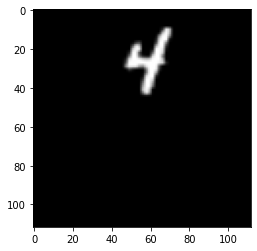

In [16]:
DataManager.plot_num(x_train[2].reshape((112, 112,)))
print(caption_rules.index_to_pos[y_train[2][0]['position']])

In [30]:
class PositionalEncoder2D(nn.Module):
    def __init__(self, c: int, h: int, w: int):
        super().__init__()
        self.w = (torch.rand((1, c, h, w)) - 0.5).requires_grad_().to(device)

    def forward(self, x):
        batch_size = x.shape[0]
        encoded = self.w.expand((batch_size, -1, -1, -1))
        return torch.cat((x, encoded), 1)

In [54]:

class PositionalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.LeakyReLU(),
            nn.Conv2d(8, 8, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.pos_enc = PositionalEncoder2D(10, 10, 10)
        self.positional_compression = nn.Sequential(
            nn.Conv2d(32 + 10, 64, 3),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3),
            nn.LeakyReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),

            nn.Linear(64, 10),
            nn.Softmax()
        )
        self.position_classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),

            nn.Linear(64, 9),
            nn.Softmax()
        )

    def forward(self, x):
        features = self.features(x)
        positional_features = self.pos_enc(features)
        compressed = self.positional_compression(positional_features)
        flattened = torch.flatten(compressed, 1)
        cls = self.classifier(flattened)
        pos = self.position_classifier(flattened)
        return cls, pos


In [55]:
model = PositionalClassifier().to(device)
position_loss = torch.nn.CrossEntropyLoss()

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [62]:

epochs = 55
batch_size = 100

for epoch in range(epochs):

    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size

        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_train[start_index:end_index]
        y_pos = torch.tensor([y[0]['position'] for y in y_batch]).to(device)
        y_cls = torch.tensor([y[0]['class'] for y in y_batch]).to(device)

        optimizer.zero_grad()

        cls, pos = model(x_batch)

        loss_pos = position_loss(pos, y_pos)
        loss_cls = position_loss(cls, y_cls)

        loss = 1 * loss_cls + 0.1 * loss_pos

        loss.backward()
        optimizer.step()

        losses += float(loss)

    print(f'Epoch: {epoch}, loss={float(losses)}')


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0, loss=174.81442666053772
Epoch: 1, loss=174.7572431564331
Epoch: 2, loss=174.7342014312744
Epoch: 3, loss=174.7099505662918
Epoch: 4, loss=174.68693554401398
Epoch: 5, loss=174.6677452325821
Epoch: 6, loss=174.64886021614075
Epoch: 7, loss=174.6637591123581
Epoch: 8, loss=174.55618751049042
Epoch: 9, loss=174.50360667705536
Epoch: 10, loss=174.426176071167
Epoch: 11, loss=174.43584072589874
Epoch: 12, loss=174.36989068984985
Epoch: 13, loss=174.32768380641937
Epoch: 14, loss=174.2971966266632
Epoch: 15, loss=174.2760648727417
Epoch: 16, loss=174.23571276664734
Epoch: 17, loss=174.20888793468475
Epoch: 18, loss=174.19324827194214
Epoch: 19, loss=174.1797400712967
Epoch: 20, loss=174.16858434677124
Epoch: 21, loss=174.15732979774475
Epoch: 22, loss=174.14530384540558
Epoch: 23, loss=174.1381540298462
Epoch: 24, loss=174.12608456611633
Epoch: 25, loss=174.0871386528015
Epoch: 26, loss=174.05083620548248
Epoch: 27, loss=174.03279995918274
Epoch: 28, loss=174.01439428329468
Epoch: 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


right right
9 9
---
bottom center
5 5
---
top-right right
3 3
---
bottom-right bottom-right
3 3
---
bottom bottom
7 8
---
bottom-right bottom-right
9 1
---
center center
4 5
---
bottom bottom
8 9
---
bottom-left bottom-left
4 4
---
top-left top-left
3 0
---


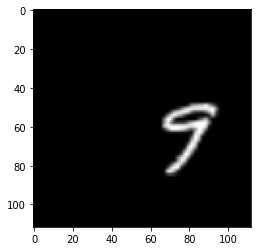

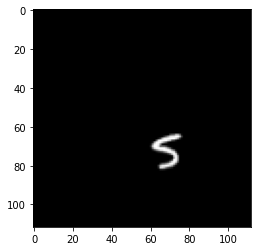

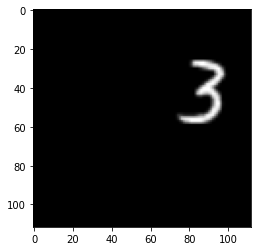

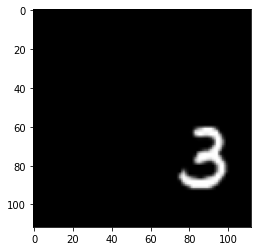

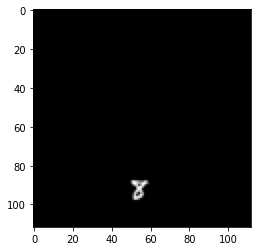

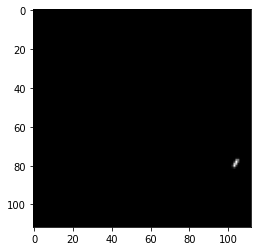

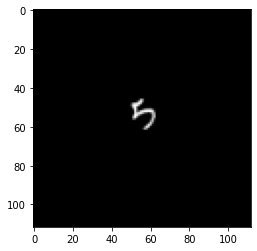

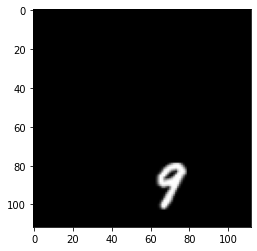

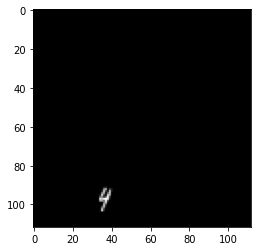

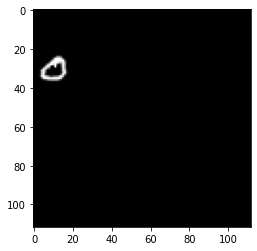

In [63]:

cls, pos = model(x_test)
_, pos = pos.max(1)
_, cls = cls.max(1)

y_test_pos = [y[0]['position'] for y in y_test]
y_test_cls = [y[0]['class'] for y in y_test]

for i in range(len(pos)):
    print(caption_rules.index_to_pos[int(pos[i])], caption_rules.index_to_pos[y_test_pos[i]])
    print(int(cls[i]), y_test_cls[i])
    print('---')
    DataManager.plot_num(x_test[i].view(112, 112).to('cpu'))


In [ ]:

pos_enc = model.pos_enc.w

c1 = pos_enc[0][0].detach().numpy()

DataManager.plot_num(c1)



In [65]:

def save_model(model, message=None):
    last_saved_model_path = f'./models/model_{int(datetime.now().timestamp())}{f"_{message}" if message else ""}.pt'
    torch.save(model.state_dict(), last_saved_model_path)
#save_model(model, message='test')



In [66]:
save_model(model)

In [72]:
!cp ./models/model* /content/gdrive/MyDrive/Projects/ML/positional_cnn.pt